# Introduction
Ever wondered why banks set different interest rate for different borrowers? Banks usually set the interest rate based on applicants prior history, income, debt to income ratio, number of accounts etc. Based on historical data, banks evaluate an applicant's probability of default, the higher the probability, the higher will be the interest rate. This project is about predicting the interest rate. This project was hosted by analyticsvidhya. The dataset and other information is available on [this link](https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-for-banking/True/#ProblemStatement). The dataset is cleaned already. Dataset has some missing values but I will use h2o which will automatically handles the missing values. The purpose of using h2o is that it automatically creates scaled variable importance, confusion matrix and other useful information which can be viewed by opening the link we get after initializing of h2o.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

## Import Dataset

In [2]:
backup_train = pd.read_csv('https://datahack-prod.s3.amazonaws.com/train_file/train_fNxu4vz.csv')
backup_test = pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/test_fjtUOL8.csv')

In [160]:
train = backup_train.copy()
test = backup_test.copy()
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].str.replace(",", "").astype(int)
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].str.replace(",", "").astype(int)

In [161]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,16000,< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [162]:
missing_values = train.isnull().sum()/len(train)
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending = False)
missing_values

Months_Since_Deliquency    0.537883
Home_Owner                 0.154276
Annual_Income              0.152773
Length_Employed            0.044861
dtype: float64

## Brief EDA

Skewness of Annual Income :  40.22530582196167


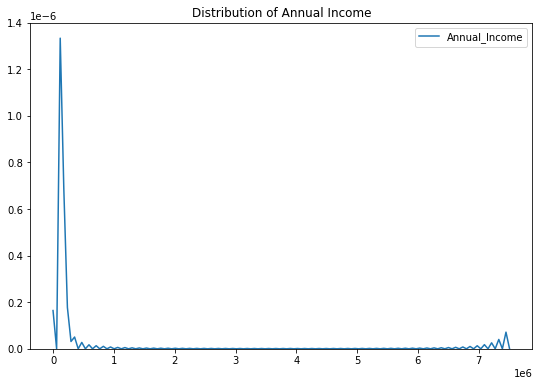

In [163]:
print("Skewness of Annual Income : ", train.Annual_Income.skew())
plt.figure(figsize = (9,6))
sns.kdeplot(train['Annual_Income'])
plt.title('Distribution of Annual Income')
plt.show()

Skewness of Loan Amount Requested :  0.7272164488493352


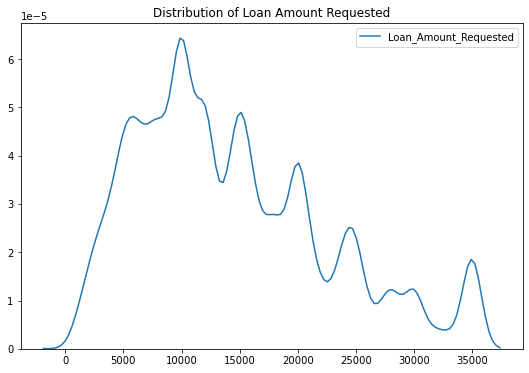

In [164]:
print("Skewness of Loan Amount Requested : ", train.Loan_Amount_Requested.skew())
plt.figure(figsize = (9,6))
sns.kdeplot(train['Loan_Amount_Requested'])
plt.title('Distribution of Loan Amount Requested')
plt.show()

Skewness of Debt To Income Ratio :  0.19220424443627823


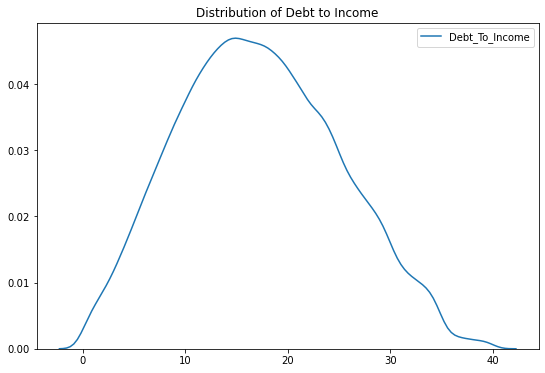

In [165]:
print("Skewness of Debt To Income Ratio : ", train.Debt_To_Income.skew())
plt.figure(figsize = (9,6))
sns.kdeplot(train['Debt_To_Income'])
plt.title('Distribution of Debt to Income')
plt.show()

Skewness of  Number of Open Accounts:  1.1640839965373095


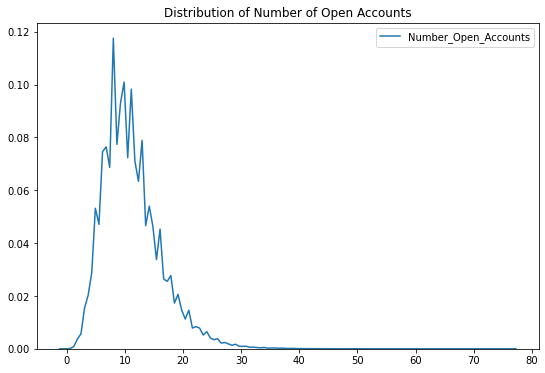

In [166]:
print("Skewness of  Number of Open Accounts: ", train.Number_Open_Accounts.skew())
plt.figure(figsize = (9,6))
sns.kdeplot(train['Number_Open_Accounts'])
plt.title('Distribution of Number of Open Accounts')
plt.show()

Skewness of Total Accounts :  0.817347341039482


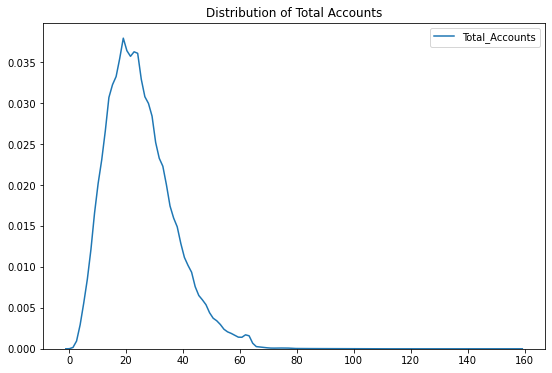

In [167]:
print("Skewness of Total Accounts : ", train.Total_Accounts.skew())
plt.figure(figsize = (9,6))
sns.kdeplot(train['Total_Accounts'])
plt.title('Distribution of Total Accounts')
plt.show()

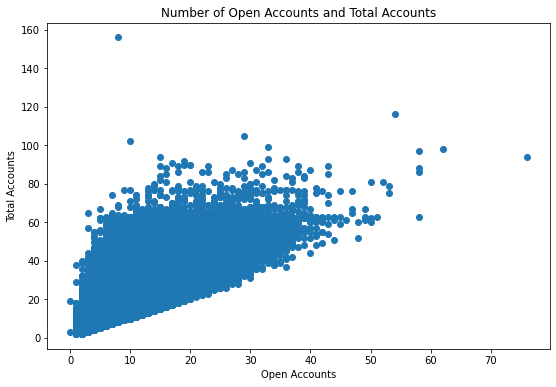

In [168]:
plt.figure(figsize=(9,6))
plt.scatter(x = train['Number_Open_Accounts'], y = train['Total_Accounts'])
plt.title('Number of Open Accounts and Total Accounts')
plt.xlabel('Open Accounts')
plt.ylabel('Total Accounts')
plt.show()

## One Hot Encoding
In order to deal with multicollinearity, I will remove the least occuring category in each categorical variable

In [169]:
cat_features = train.dtypes[train.dtypes == 'object'].index
cat_data = train[cat_features]
cat_test = test[cat_features]
dummies = pd.get_dummies(cat_data, drop_first=False)
dummies_test = pd.get_dummies(cat_test, drop_first=False)
print(dummies.shape)
print(dummies_test.shape)
dummies.head()

(164309, 35)
(109541, 35)


,Length_Employed_1 year,Length_Employed_10+ years,Length_Employed_2 years,Length_Employed_3 years,Length_Employed_4 years,Length_Employed_5 years,Length_Employed_6 years,Length_Employed_7 years,Length_Employed_8 years,Length_Employed_9 years,Length_Employed_< 1 year,Home_Owner_Mortgage,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Income_Verified_VERIFIED - income,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Purpose_Of_Loan_car,Purpose_Of_Loan_credit_card,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_educational,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Female,Gender_Male
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


## Categorical EDA

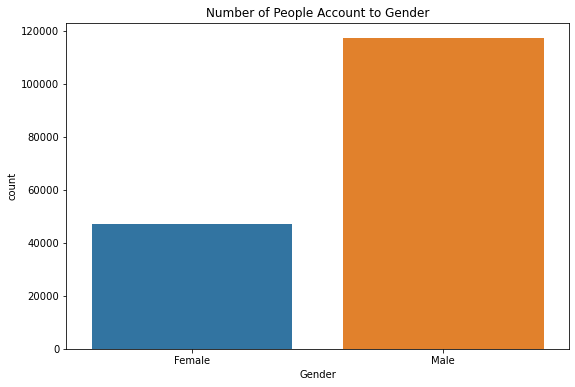

In [170]:
plt.figure(figsize=(9,6))
sns.countplot(cat_data['Gender'])
plt.title('Number of People Account to Gender')
plt.show()

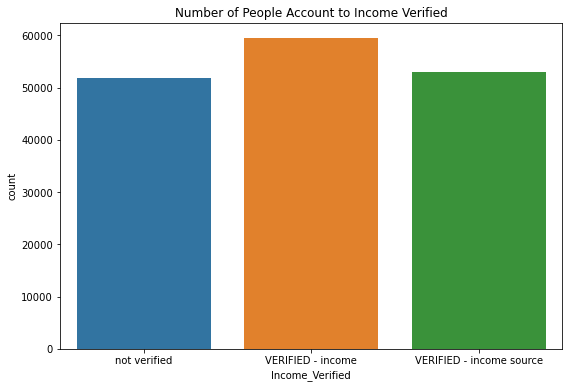

In [171]:
plt.figure(figsize=(9,6))
sns.countplot(cat_data['Income_Verified'])
plt.title('Number of People Account to Income Verified')
plt.show()

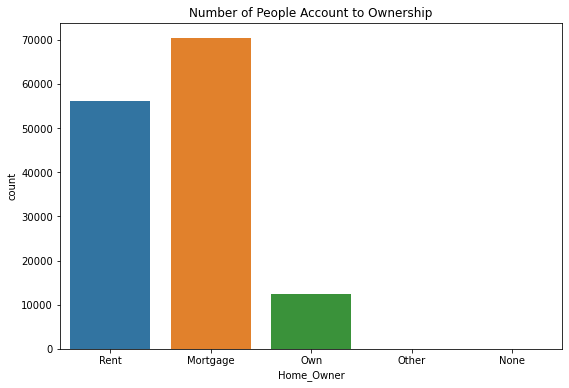

In [172]:
plt.figure(figsize=(9,6))
sns.countplot(cat_data['Home_Owner'])
plt.title('Number of People Account to Ownership')
plt.show()

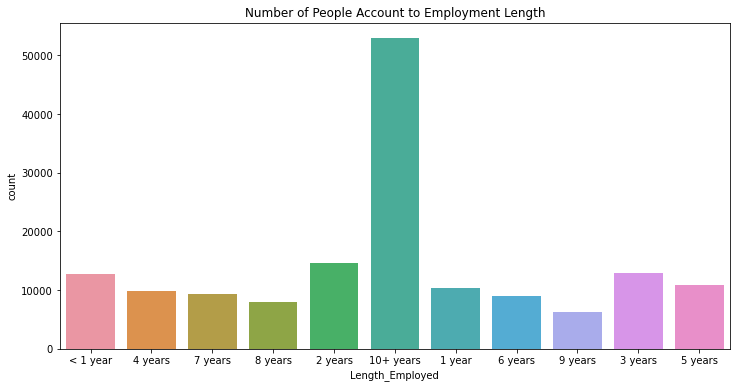

In [173]:
plt.figure(figsize=(12,6))
sns.countplot(cat_data['Length_Employed'])
plt.title('Number of People Account to Employment Length')
plt.show()

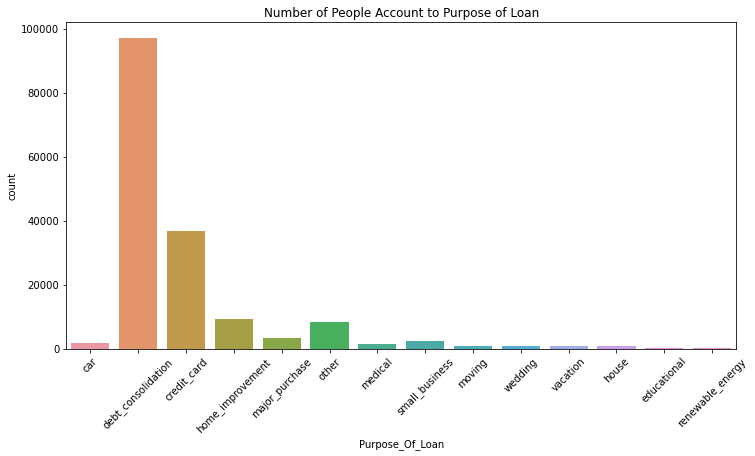

In [174]:
plt.figure(figsize=(12,6))
sns.countplot(cat_data['Purpose_Of_Loan'])
plt.title('Number of People Account to Purpose of Loan')
plt.xticks(rotation = 45)
plt.show()

In [175]:
columns_to_remove = ['Gender_Female','Purpose_Of_Loan_renewable_energy', 'Income_Verified_not verified',
                    'Home_Owner_None', 'Length_Employed_< 1 year']

dummies = dummies.drop(columns=columns_to_remove, axis = 1)
dummies_test = dummies_test.drop(columns=columns_to_remove, axis=1)
print(dummies.shape)
print(dummies_test.shape)

(164309, 30)
(109541, 30)


In [176]:
train = pd.concat([train, dummies], axis=1)
test = pd.concat([test, dummies_test], axis=1)
print(train.shape)
print(test.shape)

(164309, 44)
(109541, 43)


In [177]:
num_features = train.dtypes[train.dtypes != 'object'].index
final_train = train[num_features]
final_test = test[test.dtypes[test.dtypes != 'object'].index]

In [178]:
final_train.head()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate,Length_Employed_1 year,Length_Employed_10+ years,Length_Employed_2 years,Length_Employed_3 years,Length_Employed_4 years,Length_Employed_5 years,Length_Employed_6 years,Length_Employed_7 years,Length_Employed_8 years,Length_Employed_9 years,Home_Owner_Mortgage,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Income_Verified_VERIFIED - income,Income_Verified_VERIFIED - income source,Purpose_Of_Loan_car,Purpose_Of_Loan_credit_card,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_educational,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Male
0,10000001,7000,68000.0,18.37,0,NaN,9,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10000002,30000,NaN,14.93,0,17.0,12,24,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,10000003,24725,75566.4,15.88,0,NaN,12,16,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,10000004,16000,56160.0,14.34,3,NaN,16,22,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,10000005,17000,96000.0,22.17,1,NaN,19,30,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Preprocessing

In [179]:
final_train['Annual_Income'] = np.log(final_train['Annual_Income'])
final_test['Annual_Income'] = np.log(final_test['Annual_Income'])

# Start H2o

In [180]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,55 mins 46 secs
H2O_cluster_timezone:,Asia/Dubai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_uzairahmed_fdqlte
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.845 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [181]:
train_h2o = h2o.H2OFrame(final_train)
test_h2o = h2o.H2OFrame(final_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [182]:
train_h2o = train_h2o.drop('Loan_ID')
test_h2o = test_h2o.drop('Loan_ID')

In [183]:
train_h2o['Interest_Rate'] = train_h2o['Interest_Rate'].asfactor()

In [184]:
y = 'Interest_Rate'
x = list(train_h2o.columns)
x.remove(y)

In [185]:
# from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
# from h2o.grid.grid_search import H2OGridSearch

## Xgboost

In [186]:
param = {
    "max_depth" : 9,
    "learn_rate" : 0.1,
    "sample_rate" : 0.7,
    "col_sample_rate_per_tree" : 0.9,
    "ntrees": 300,
    "stopping_rounds":10,
    "stopping_tolerance":0.001,
    "stopping_metric":'mean_per_class_error',
    "distribution": "multinomial",
    "seed":42,
    "sample_rate":0.9,
    "fold_assignment":"Modulo",
    "nfolds" : 5,
    "keep_cross_validation_predictions":True
}
xgb = H2OXGBoostEstimator(**param)

In [187]:
xgb.train(x=x,
          y=y,
          training_frame = train_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


## Random Forest

In [188]:
rf = H2ORandomForestEstimator(ntrees = 50,
                              max_depth = 20,
                              nfolds = 5,
                              fold_assignment = "Modulo",
                              keep_cross_validation_predictions=True)

rf.train(x=x,
         y=y,
         training_frame=train_h2o,
         model_id = 'rf')

drf Model Build progress: |███████████████████████████████████████████████| 100%


## Gradient Boosting 

In [189]:
gbm = H2OGradientBoostingEstimator(ntrees = 200,
                                   max_depth = 7,
                                   learn_rate = 0.01,
                                   seed = 42,
                                   distribution = 'multinomial',
                                   nfolds = 5,
                                   fold_assignment = "Modulo",
                                   balance_classes = True,
                                   stopping_rounds = 10,
                                   stopping_tolerance = 0.001,
                                   stopping_metric = 'mean_per_class_error',
                                   keep_cross_validation_predictions=True)
gbm.train(x=x,
          y=y,
          training_frame=train_h2o,
          model_id = 'gbm')

gbm Model Build progress: |███████████████████████████████████████████████| 100%


## Stacked Ensemble

In [192]:
stack_blend = H2OStackedEnsembleEstimator(base_models=[rf.model_id, gbm.model_id, xgb.model_id],
                                          seed=42)

stack_blend.train(x=x,
                  y=y,
                  training_frame=train_h2o)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [194]:
result = stack_blend.predict(test_h2o)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [197]:
predictions = h2o.as_list(result)
predictions.head()

,predict,p1,p2,p3
0,2,0.234083,0.442597,0.323320
1,1,0.546638,0.364778,0.088584
2,3,0.082874,0.350497,0.566628
3,2,0.197691,0.528902,0.273407
4,2,0.123268,0.533398,0.343335


## Preparing data for submission

In [198]:
submission = pd.DataFrame()
submission['Loan_ID'] = test['Loan_ID']
submission['Interest_Rate'] = predictions['predict']
submission.to_csv('loan_pred.csv', index = False)

In [199]:
h2o.cluster().shutdown()

H2O session _sid_b404 closed.


Final result is weighted f1 of 0.530, highest score in the competition is 0.5399, which means that our model is good enough overall. Although the hyperparameters were randomly selected for all the models. In order to get higher score, h2o grid search can be used to tune the models. Thank you for checking out my kernel.